# Notebook 4:  Kiliminjaro Safaris EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

In [2]:
safari_posted = pd.read_csv('data/safari_posted2.csv')
safari_actl = pd.read_csv('data/safari_actl.csv')

In [3]:
safari_posted.dtypes

Unnamed: 0      int64
date           object
datetime       object
SACTMIN       float64
SPOSTMIN      float64
weekday         int64
day_name       object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
safari_posted['date'] = pd.to_datetime(safari_posted['date'])
safari_posted['datetime'] = pd.to_datetime(safari_posted['datetime'])

safari_actl['date'] = pd.to_datetime(safari_actl['date'])
safari_actl['datetime'] = pd.to_datetime(safari_actl['datetime'])


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
safari_date = safari_posted.copy()
safari_date.set_index('date', inplace=True)


safari_dt = safari_posted.copy()
safari_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = safari_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = safari_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = safari_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

safari_posted.set_index('date', inplace = True)
safari_actl.set_index('date', inplace = True)

In [5]:
safari_posted.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name
date,,,,,,
2015-01-01,0,2015-01-01 07:47:26,NaN,5.0,4,Thursday
2015-01-01,1,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2015-01-01,2,2015-01-01 08:05:33,NaN,5.0,4,Thursday
2015-01-01,3,2015-01-01 08:12:23,NaN,10.0,4,Thursday
2015-01-01,4,2015-01-01 08:19:26,NaN,10.0,4,Thursday


# EDA - Kiliminjaro Safaris

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

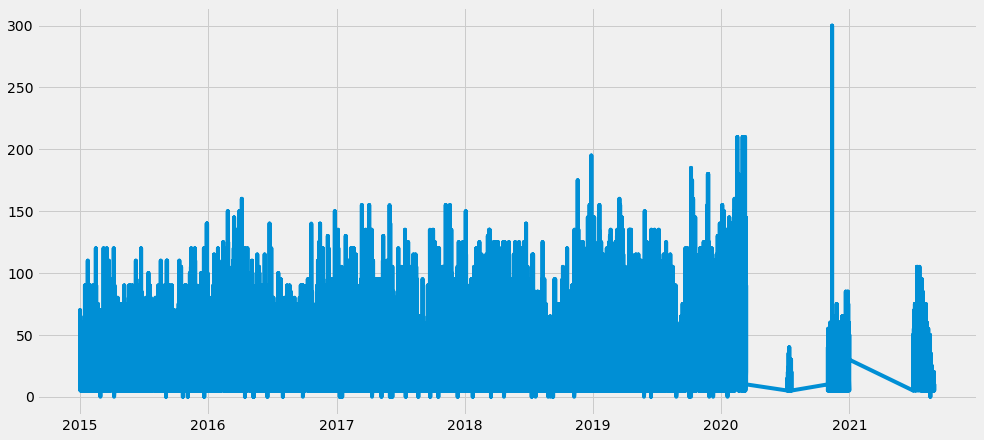

In [6]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(safari_posted['SPOSTMIN']);

In [7]:
print(f"Minimum Wait: {safari_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {safari_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 300.0


In [8]:
safari_posted.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name
date,,,,,,
2015-01-01,0,2015-01-01 07:47:26,NaN,5.0,4,Thursday
2015-01-01,1,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2015-01-01,2,2015-01-01 08:05:33,NaN,5.0,4,Thursday
2015-01-01,3,2015-01-01 08:12:23,NaN,10.0,4,Thursday
2015-01-01,4,2015-01-01 08:19:26,NaN,10.0,4,Thursday


Because of missing data and the covid closure (March 15 - July 11, 2020), I want to separate the precovid data from the covid data.  Since covid began affecting tourism by the end of 2018, the end date for "precovid" data is 12/31/2018.

In [9]:
precovid_daily.head()

,Unnamed: 0,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01
1,1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday,2015-01-01
2,2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday,2015-01-01
3,3,2015-01-01,2015-01-01 08:12:23,NaN,10.0,4,Thursday,2015-01-01
4,4,2015-01-01,2015-01-01 08:19:26,NaN,10.0,4,Thursday,2015-01-01


In [10]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2020-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,,
2015-01-01,78,2015-01-01 16:26:23,NaN,30.0,4,Thursday,2015-01-01,29.276316
2015-01-02,159,2015-01-02 16:32:23,NaN,10.0,5,Friday,2015-01-02,34.155844
2015-01-03,240,2015-01-03 16:47:23,NaN,10.0,6,Saturday,2015-01-03,19.551282
2015-01-04,312,2015-01-04 16:54:23,NaN,10.0,7,Sunday,2015-01-04,16.478873
2015-01-05,381,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,14.393939


In [11]:
covid.drop(['Unnamed: 0'], axis=1)

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
170685,2019-07-16,2019-07-16 08:59:02,NaN,5.0,2,Tuesday,2019-07-16
170686,2019-07-16,2019-07-16 09:53:45,NaN,15.0,2,Tuesday,2019-07-16
170687,2019-07-16,2019-07-16 09:59:02,NaN,55.0,2,Tuesday,2019-07-16
170688,2019-07-16,2019-07-16 10:00:47,NaN,55.0,2,Tuesday,2019-07-16
170689,2019-07-16,2019-07-16 10:10:02,NaN,15.0,2,Tuesday,2019-07-16
...,...,...,...,...,...,...,...
204159,2021-08-31,2021-08-31 18:31:15,NaN,5.0,2,Tuesday,2021-08-31
204160,2021-08-31,2021-08-31 18:38:11,NaN,5.0,2,Tuesday,2021-08-31
204161,2021-08-31,2021-08-31 18:45:11,NaN,5.0,2,Tuesday,2021-08-31
204162,2021-08-31,2021-08-31 18:52:11,NaN,5.0,2,Tuesday,2021-08-31


In [12]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2019-01-01']
#precovid_daily.set_index('date', inplace=True)

# Saving these dataframes for future use
custom = precovid_daily.copy()
custom_covid = safari_posted.copy()

# Group waiting times by date to get avg_daily_posted_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')


In [13]:
precovid_daily.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,,
2015-01-01,78,2015-01-01 16:26:23,NaN,30.0,4,Thursday,2015-01-01,30.0
2015-01-02,159,2015-01-02 16:32:23,NaN,10.0,5,Friday,2015-01-02,10.0
2015-01-03,240,2015-01-03 16:47:23,NaN,10.0,6,Saturday,2015-01-03,10.0
2015-01-04,312,2015-01-04 16:54:23,NaN,10.0,7,Sunday,2015-01-04,10.0
2015-01-05,381,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,10.0


In [14]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,,
2019-07-16,183438,2019-07-16 20:59:01,NaN,10.0,2,Tuesday,2019-07-16,50.217391
2019-07-17,183541,2019-07-17 20:59:02,NaN,10.0,3,Wednesday,2019-07-17,45.346535
2019-07-18,183656,2019-07-18 22:31:02,NaN,15.0,4,Thursday,2019-07-18,36.359649
2019-07-19,183757,2019-07-19 20:59:01,NaN,15.0,5,Friday,2019-07-19,38.200000
2019-07-20,183862,2019-07-20 20:59:02,NaN,25.0,6,Saturday,2019-07-20,42.596154


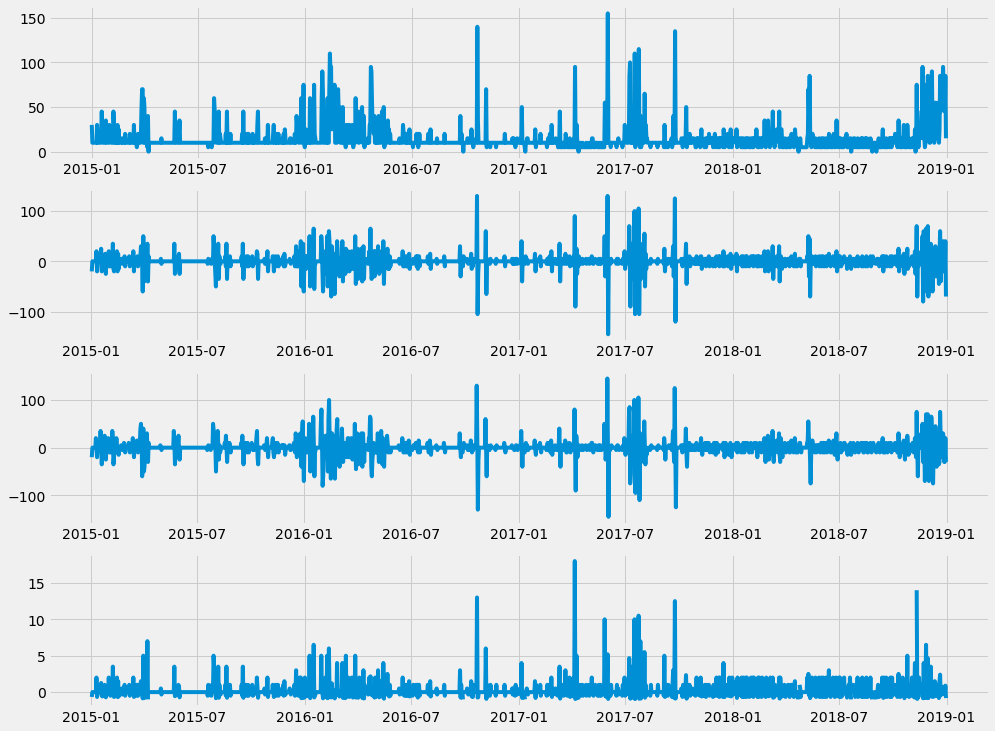

In [15]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  The top plot shows increased wait times during the first half of 2016, late October, 2016, spring break, 2017, June, 2017, and sometime in October, 2017.  This is not the kind of seasonality that is accounted for in most (all?) built-in models.

Ultimately, there is some evidence of seasonality that I will investigate further in the modeling section.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.

In [16]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       16.473430
Monday       12.596154
Saturday     17.788462
Sunday       14.951923
Thursday     16.514423
Tuesday      12.668269
Wednesday    13.028846
Name: avg_daily_wait, dtype: float64

Average daily wait time for Kiliminjaro Safaris was very low in its early months.  Based on this summary, Based on this summary, Mondays and Tuesdays have the shortest waits, and Saturdays have the longest.  The difference is only 5 minutes, but that's about 1/3 of the waiting time, depending on the day.  I've personally experienced much longer wait times for this ride, though admittedly wait times seldom exceed 1 hour, and wait times that long are often animal related, rather than crowd-related.

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [17]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

safari_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
safari_Wed_Dec_05.set_index('datetime', inplace = True)

In [18]:
print(f"Minimum wait: {safari_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {safari_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 115.0


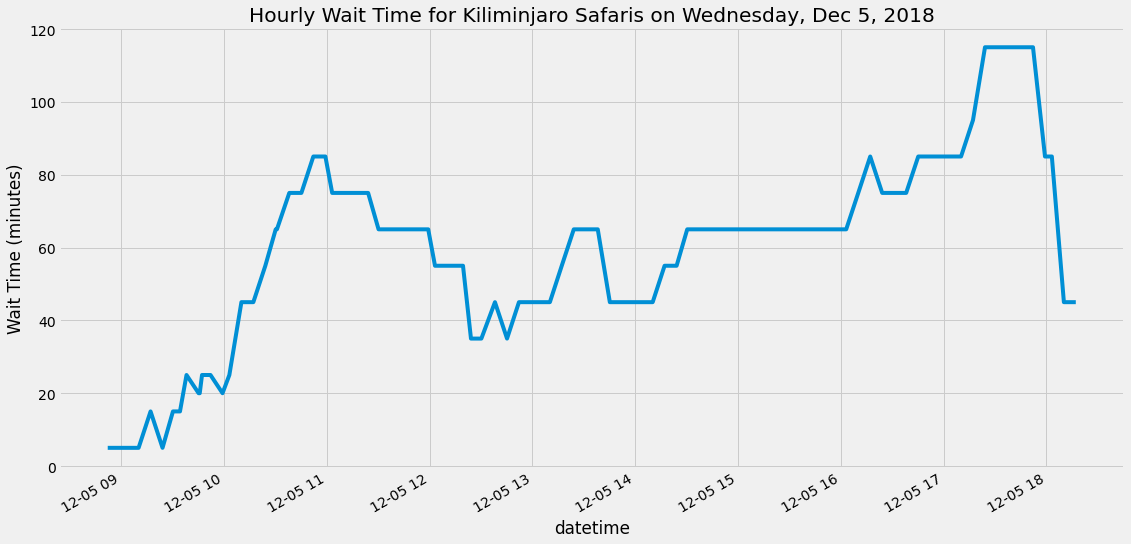

In [19]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Kiliminjaro Safaris on Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

safari_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [20]:
# Step 3: Create data for Saturday, Dec 8, 2018

safari_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
safari_Sat_Dec_08.set_index('datetime', inplace = True)

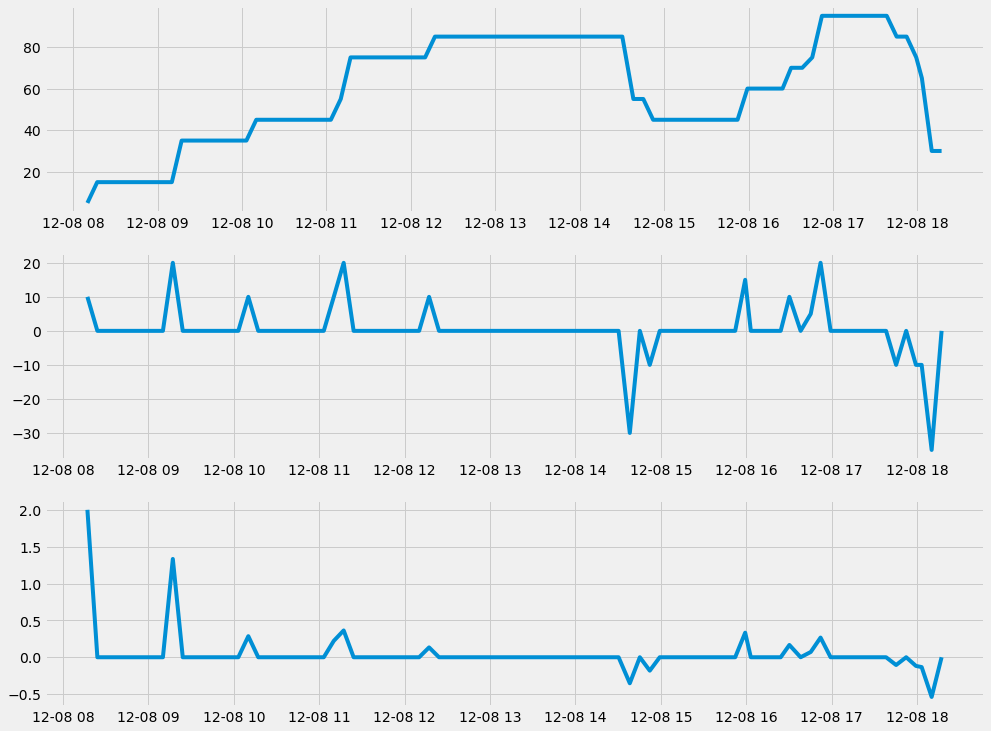

In [21]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(safari_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(safari_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(safari_Sat_Dec_08['SPOSTMIN'].pct_change());

In [22]:
print(f"Minimum wait: {safari_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {safari_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 95.0


The two hourly plots differ substantially.  The Wednesday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Saturday plot has several ebbs and flows, including two (around 10AM and 5-5:30PM) when the wait time drops to about 50 minutes.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

In [23]:
# Step 5: Create df for Saturdays only
safari_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()
saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays = saturdays.groupby('date')

In [24]:
saturdays.head()

,Unnamed: 0,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
153,160,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday
154,161,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday
155,162,2015-01-03,2015-01-03 08:05:24,NaN,10.0,6,Saturday
156,163,2015-01-03,2015-01-03 08:12:23,NaN,10.0,6,Saturday
157,164,2015-01-03,2015-01-03 08:19:29,NaN,10.0,6,Saturday
...,...,...,...,...,...,...,...
185794,198764,2019-12-28,2019-12-28 08:10:02,NaN,5.0,6,Saturday
185795,198765,2019-12-28,2019-12-28 08:17:02,NaN,5.0,6,Saturday
185796,198766,2019-12-28,2019-12-28 08:24:02,NaN,5.0,6,Saturday
185797,198767,2019-12-28,2019-12-28 08:31:02,NaN,5.0,6,Saturday


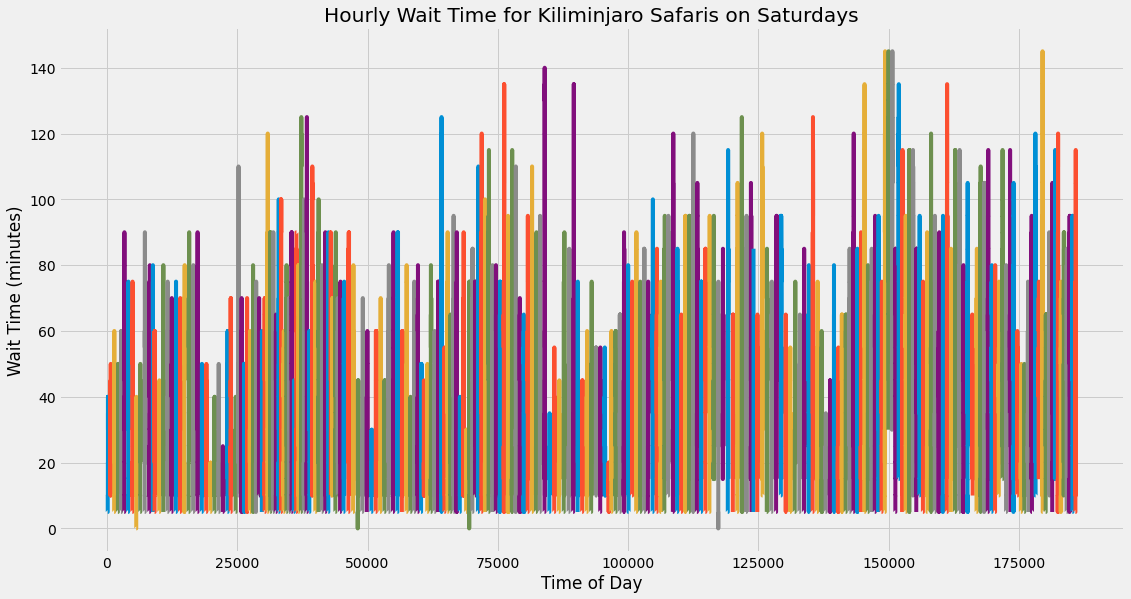

In [25]:
# Step 6: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Kiliminjaro Safaris on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be some hourly seasonality for Saturdays, but it's very difficult to tell in this plot.  I'll revisit this in the SARIMAX model.

## Weekly Seasonality

In [26]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

precovid_weekly['week_number'] = precovid_weekly['week_num']

# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(208, 11)

In [27]:
precovid_weekly.drop(['Unnamed: 0'], axis=1)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2015-01-07,2015-01-07 16:54:22,NaN,10.0,3,Wednesday,2015-01-07,10.0,6,0,12.857143
2015-01-14,2015-01-14 17:00:09,NaN,10.0,3,Wednesday,2015-01-14,10.0,13,1,12.857143
2015-01-21,2015-01-21 17:00:07,NaN,10.0,3,Wednesday,2015-01-21,10.0,20,2,18.571429
2015-01-28,2015-01-28 13:14:09,NaN,10.0,3,Wednesday,2015-01-28,10.0,27,3,15.000000
2015-02-04,2015-02-04 17:15:05,NaN,10.0,3,Wednesday,2015-02-04,10.0,34,4,15.714286
...,...,...,...,...,...,...,...,...,...,...
2018-12-04,2018-12-04 18:10:12,NaN,10.0,2,Tuesday,2018-12-04,10.0,1427,203,23.571429
2018-12-11,2018-12-11 18:17:09,NaN,10.0,2,Tuesday,2018-12-11,10.0,1434,204,41.428571
2018-12-18,2018-12-18 18:10:08,NaN,55.0,2,Tuesday,2018-12-18,55.0,1441,205,35.000000


In [28]:
# copy dataframe for backup
covid_weekly = covid.copy()

# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()
#covid_weekly = covid_weekly.drop_duplicates(subset='week_number', keep='last')

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,,
2019-07-22,184066,2019-07-22 20:59:01,NaN,10.0,1,Monday,2019-07-22,10.0,6,0,13.571429
2019-07-29,184787,2019-07-29 20:59:02,NaN,10.0,1,Monday,2019-07-29,10.0,13,1,15.000000
2019-08-05,185496,2019-08-05 20:59:02,NaN,15.0,1,Monday,2019-08-05,15.0,20,2,13.571429
2019-08-12,186236,2019-08-12 20:52:02,NaN,10.0,1,Monday,2019-08-12,10.0,27,3,9.285714
2019-08-19,186955,2019-08-19 20:24:02,NaN,15.0,1,Monday,2019-08-19,15.0,34,4,12.142857


### Weekly EDA

In [29]:
precovid_weekly.set_index('date2', inplace=True)

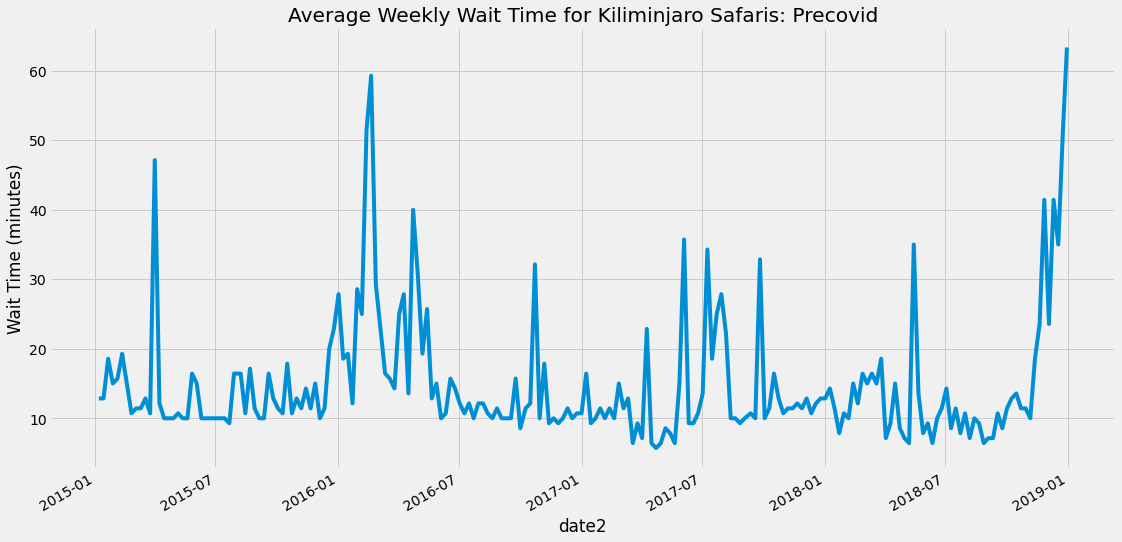

In [30]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Kiliminjaro Safaris: Precovid")
plt.xlabel('Week Number')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

I'm seeing typical seasonality for a tourist attraction.  I see spikes around spring break and Christmas.  The spikes in February and December, 2018 are particularly sharp.  The spikes for other rides weren't as distinct relative to the rest of the year.

# Modeling

## Null Model

In [31]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

41.01087406181668

Personally, I love this ride.  You see rare animals in a semi-natural habitat.  You ride around in a safari-like vehicle while the animals roam freely.  Sometimes one blocks your path and your vehicle (and all vehicles behind you) stops at a safe distance until the animal walks away.  All that said, if the typical wait time is 42 minutes and you're not planning to ride Flight of Passage, then Genie+ is probably not worth it the cost.

##  Weekly ACF and PACF Plots

In [32]:
precovid_weekly.shape

(208, 10)

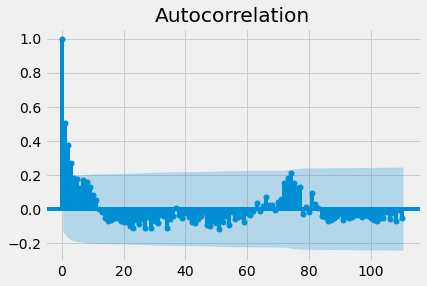

In [33]:
# Weekly ACF plot for May 26, 2017 - July, 15, 2019: pre-covid
plot_acf(precovid_weekly['avg_weekly_wait'], lags=110)
plt.show()

This ride opened in late January, 2015.  It took awhile to gain popularity.  Aside from the initial few lags, there's not really any significant autocorrelation.

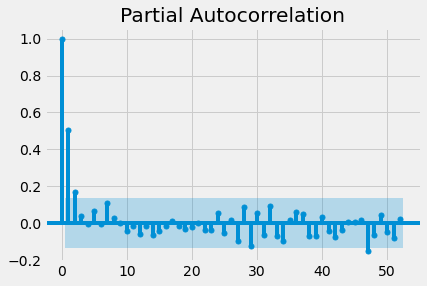

In [34]:
# Weekly PACF plot for May 26, 2017 - July, 15, 2019: pre-covid
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=52)
plt.show()

There's some partial autocorrelation in the first 3 lags and some marginal (negative) partial autocorrelation in lags 29 and 47.  I really can't explain the latter.

### 90 Day ACF and PACF Plots

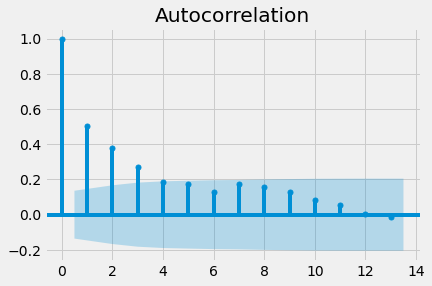

In [35]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_acf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

There is substantial autocorrelation for about 4 weeks.

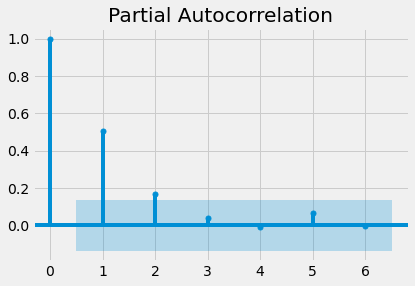

In [36]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=6)
plt.show()

However, after the second interval, there is no significant partial autocorrelation.

In [37]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])

In [38]:
# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2015-01-07,12.857143
2015-01-14,12.857143
2015-01-21,18.571429
2015-01-28,15.000000
2015-02-04,15.714286
...,...
2018-11-28,38.877551
2018-12-05,26.122449
2018-12-12,40.510204


In [39]:
#model = pmd.auto_arima(precovid_weekly_3['avg_weekly_wait'], m=52, trace=True)

In [40]:
sarimax_model = sm.tsa.statespace.SARIMAX(precovid_weekly_3['avg_weekly_wait'], order=(1,1,1), seasonal_order=(0, 0, 2, 52))
safari_results = sarimax_model.fit()

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44320D+00    |proj g|=  4.41129D-02


 This problem is unconstrained.



At iterate    5    f=  3.43467D+00    |proj g|=  3.71923D-03

At iterate   10    f=  3.43454D+00    |proj g|=  8.95267D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   5.020D-06   3.435D+00
  F =   3.4345336164190337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [41]:
# Mean absolute error
print(f'Mean absolute error: {safari_results.mae}')
print(f'Mean squared error: {safari_results.mse}')

Mean absolute error: 4.791091509659619
Mean squared error: 58.63815748661932


In [42]:
# print summary of fit model
print(safari_results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                         avg_weekly_wait   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 52)   Log Likelihood                -714.383
Date:                                 Mon, 25 Oct 2021   AIC                           1438.766
Time:                                         09:21:26   BIC                           1455.430
Sample:                                              0   HQIC                          1445.505
                                                 - 208                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1780      0.092      1.928      0.054      -0.003       0

In [43]:
# Are the data stationary?  Here's an adfuller test:

adfuller(precovid_weekly_3['avg_weekly_wait'])

(-3.9621036339268634,
 0.0016224783919159083,
 1,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 1313.4835353152307)

With an alpha of .05 and a p-value of .00162, the data are stationary.

# Pickle

In [44]:
with open('models/safari_results.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(safari_results, pickle_out)

Perhaps Disney's "seasons" are too frequent and dynamic (due to shifting holiday periods at spring break and Thanksgiving) for adfuller tests and SARIMAX models to grasp.  At a glance, the data don't appear stationary and the partial autocorrelation plots above indicate fluctuation.  Perhaps predicting wait times requires a customized approach.

I'm going to create a custom model based on Disney's seasonality.  I'll used their published blockout dates for lower-level annual passholders and cast members (plus Thanksgiving week for previous years) to predict when ride times likely are longest.  Then, I'll calculate an adjustment factor using pre- and covid crowds to predict wait times from October 29th, 2021 - January 1, 2022.

## Predict Wait Times

In [45]:
covid_weekly_3 = covid_weekly[['avg_weekly_wait']]
covid_weekly_3.head()

,avg_weekly_wait
date,
2019-07-22,13.571429
2019-07-29,15.000000
2019-08-05,13.571429
2019-08-12,9.285714
2019-08-19,12.142857


In [46]:
# Predictions
start_index = 0
end_index = len(covid_weekly_3)
forecast = safari_results.predict(start=start_index, end=end_index)

In [47]:
forecast

date2
2015-01-07     0.000000
2015-01-14    12.856790
2015-01-21    12.856950
2015-01-28    15.978004
2015-02-04    15.017505
2015-02-11    15.364477
2015-02-18    17.206582
2015-02-25    15.773132
2015-03-04    13.482286
2015-03-11    12.991019
2015-03-18    12.521208
2015-03-25    12.876470
2015-04-01    11.845531
2015-04-08    28.931204
2015-04-15    17.658876
2015-04-22    14.977572
2015-04-29    13.482927
2015-05-06    12.437099
2015-05-13    12.046948
2015-05-20    11.305149
2015-05-27    10.913251
2015-06-03    13.713786
2015-06-10    13.845676
2015-06-17    11.800808
2015-06-24    11.260079
2015-07-01    10.881715
2015-07-08    10.616962
2015-07-15    10.431707
2015-07-22    10.302078
2015-07-29     9.869734
2015-08-08    13.110766
2015-08-15    14.107003
2015-08-22    12.070984
2015-08-29    14.738364
2015-09-05    12.727245
2015-09-12    11.654013
2015-09-19    11.157363
2015-09-26    13.884597
2015-10-03    12.940279
2015-10-10    12.232036
2015-10-17    11.649140
2015-10-24

In [48]:
predictions = pd.DataFrame(forecast)
predictions.head()

,predicted_mean
date2,
2015-01-07,0.000000
2015-01-14,12.856790
2015-01-21,12.856950
2015-01-28,15.978004
2015-02-04,15.017505


In [49]:
df_final = precovid_weekly_3.merge(predictions, left_on='date2', right_on='date2')
df_final.head()

,avg_weekly_wait,predicted_mean
date2,,
2015-01-07,12.857143,0.000000
2015-01-14,12.857143,12.856790
2015-01-21,18.571429,12.856950
2015-01-28,15.000000,15.978004
2015-02-04,15.714286,15.017505


In [50]:
df_final['resids'] = df_final['predicted_mean'] - df_final['avg_weekly_wait']

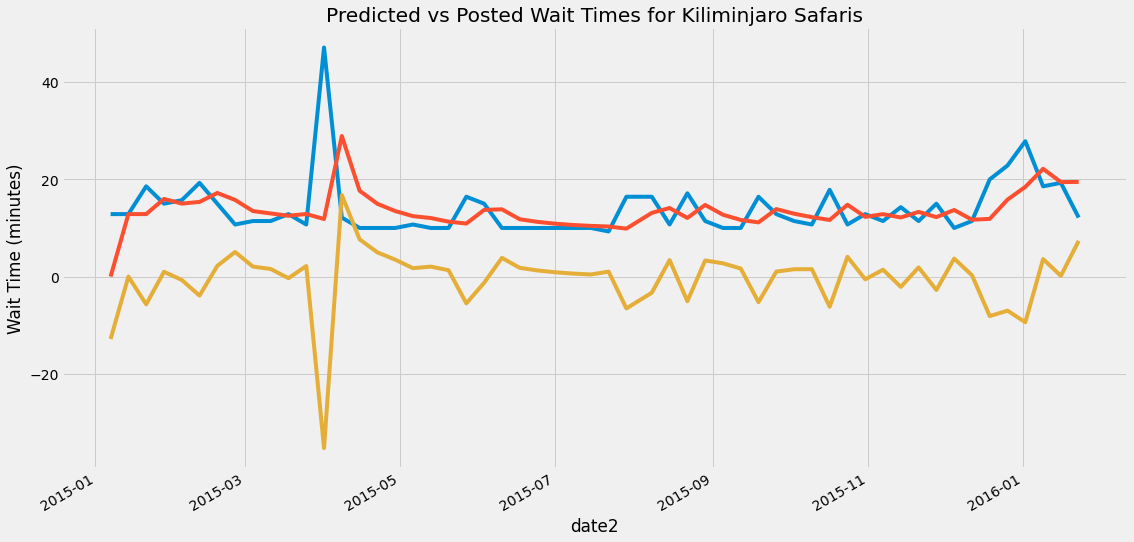

In [51]:
plt.figure(figsize = (17, 9))
plt.title("Predicted vs Posted Wait Times for Kiliminjaro Safaris")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')

df_final['avg_weekly_wait'].plot()
df_final['predicted_mean'].plot()
df_final['resids'].plot()
plt.legend;

In [52]:
# Create customized dataframes for Halloween - New Year's Day, 2016, 2017, and 2018

custom15 = custom[custom['date2'] > '2015-10-30']
custom15 = custom15[custom15['date2'] < '2016-01-03']
custom16 = custom[custom['date2'] > '2016-10-29']
custom16 = custom16[custom16['date2'] < '2017-01-03']
custom17 = custom[custom['date2'] > '2017-10-27']
custom17 = custom17[custom17['date2'] < '2018-01-03']
custom18 = custom[custom['date2'] > '2018-10-28']
custom18 = custom18[custom18['date2'] < '2019-01-04']

In [53]:
# Create date2 column and convert it to date type
custom_covid['date2'] = custom_covid['datetime'].dt.date
custom_covid['date2'] = pd.to_datetime(custom_covid['date2'])

In [54]:
custom_covid.head()

,Unnamed: 0,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
date,,,,,,,
2015-01-01,0,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01
2015-01-01,1,2015-01-01 07:54:23,NaN,5.0,4,Thursday,2015-01-01
2015-01-01,2,2015-01-01 08:05:33,NaN,5.0,4,Thursday,2015-01-01
2015-01-01,3,2015-01-01 08:12:23,NaN,10.0,4,Thursday,2015-01-01
2015-01-01,4,2015-01-01 08:19:26,NaN,10.0,4,Thursday,2015-01-01


In [55]:
custom_covid.dtypes

Unnamed: 0             int64
datetime      datetime64[ns]
SACTMIN              float64
SPOSTMIN             float64
weekday                int64
day_name              object
date2         datetime64[ns]
dtype: object

In [56]:
custom_covid19 = custom_covid[custom_covid['date2'] > '2019-10-31']
custom_covid19 = custom_covid19[custom_covid19['date2'] < '2020-01-05']
custom_covid20 = custom_covid[custom_covid['date2'] > '2020-10-31']
custom_covid20 = custom_covid20[custom_covid20['date2'] < '2021-01-02']

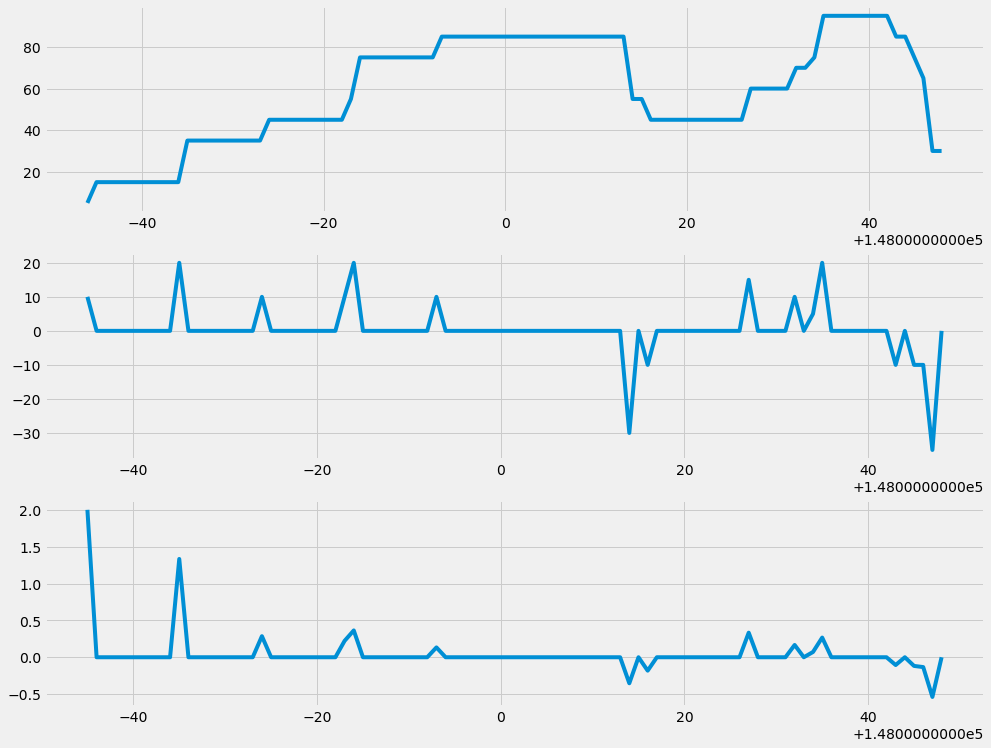

In [57]:
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(safari_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(safari_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(safari_Sat_Dec_08['SPOSTMIN'].pct_change());

NameError: name 'custom1' is not defined

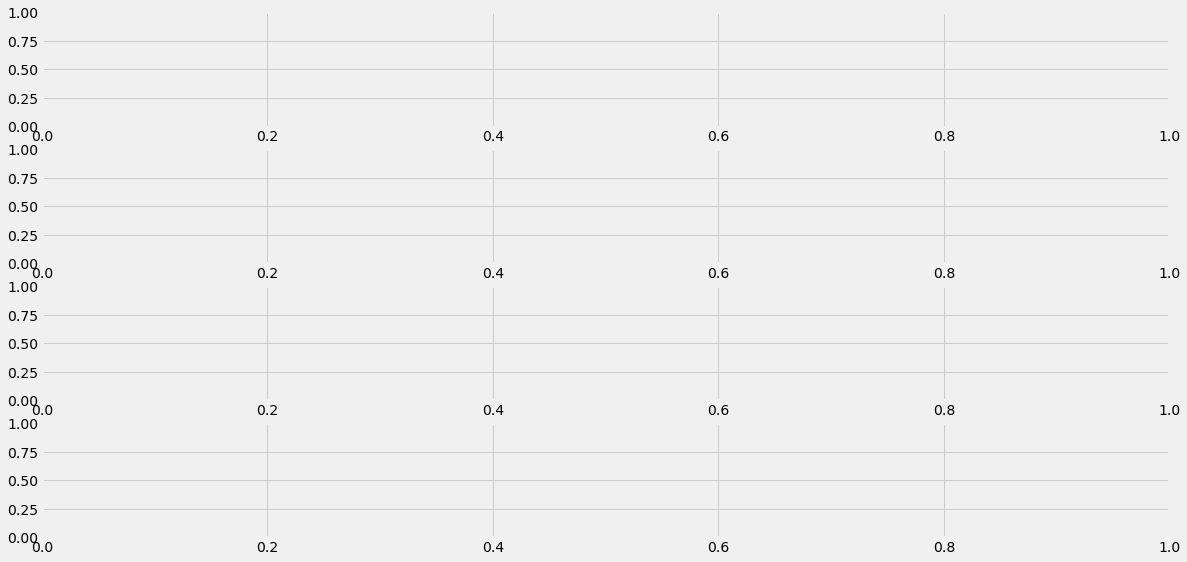

In [58]:
fig, axes = plt.subplots(nrows = 4, figsize = (18, 9))

axes[0].plot(custom1['SPOSTMIN'], label='2015')
axes[1].plot(custom2['SPOSTMIN'], label='2016')
axes[2].plot(custom3['SPOSTMIN'], label='2017')
axes[3].plot(custom4['SPOSTMIN'], label='2018')

plt.ylabel('Autumn Wait Times', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18);

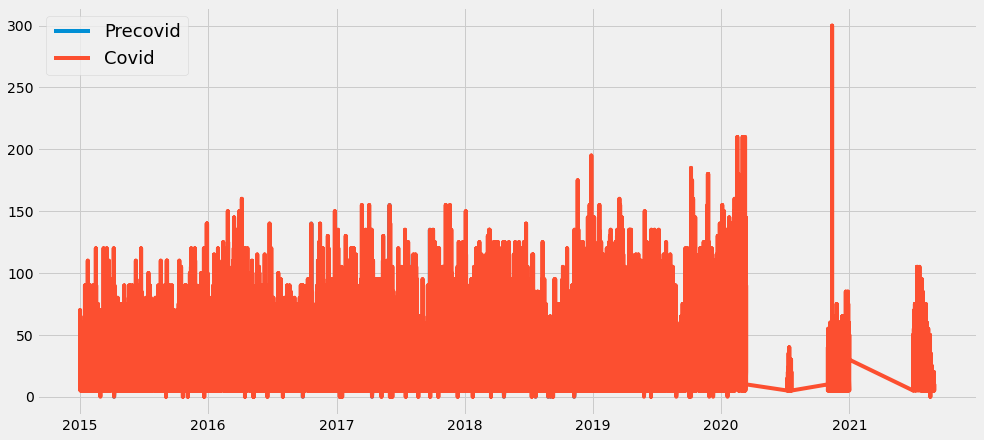

In [59]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(custom['SPOSTMIN'], label = 'Precovid')
plt.plot(custom_covid['SPOSTMIN'], label = 'Covid')
plt.legend(fontsize=18);

In [62]:
# multiline plot showing different years
#data = data[data.columns.tolist()[3:]] # use only Temp, Month, Day

#for key, grp in data.groupby(['month']):
#    ax2.plot(grp['day'], grp['avg_daily_wait'], label = 'Wait Time in Minutes'.format(key))

In [61]:
covid_weekly_3.to_csv('data/safari_covid_weekly3.csv', index=True)